# Dependencies

In [1]:
import sys
import os
import torch
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold

sys.path.append(os.path.abspath('/projects/renal/srm_detection_main'))

from models.classification.classifier import cnn_classifier, xgboost, xgboost_trainer
from models.classification.cnn import PatNET
from data.dataloaders import load_classification_data, load_xgboost_data
from data.dataset import CNNDataset
from evaluation.classification.evaluate import bootstrap_ci, get_cnn_predictions, get_xgb_predictions, get_cnn_val_data_from_fold_indices, load_val_xgboost_data, evaluate_model
from utils import *

2024-09-11 02:41:49.793642: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-11 02:41:49.797565: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-11 02:41:49.861630: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 1. Load data

In [2]:
X_train_cnn, y_train_cnn, id_train_cnn, X_test_cnn, y_test_cnn, id_test_cnn, aug_pos_data_dict, aug_neg_data_dict, pos_data_dict, neg_data_dict = load_classification_data("grade", "cnn")


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Concatenation ...
Number of Patients ready for training: 257
Negative Data:
140

Positive Data:
109


  0%|          | 0/140 [00:00<?, ?it/s]

100%|██████████| 109/109 [16:33<00:00,  9.12s/it] 


Total original negative samples: 140
Total augmented negative samples: 980
Total original positive samples: 109
Total augmented positive samples: 981


Processing Non ccRCC Patients:   0%|          | 0/5 [00:00<?, ?it/s]invalid value encountered in scalar divide
32it [00:00, 57.70it/s]
Processing Augmented Patients: 100%|██████████| 31/31 [00:17<00:00,  1.81it/s]


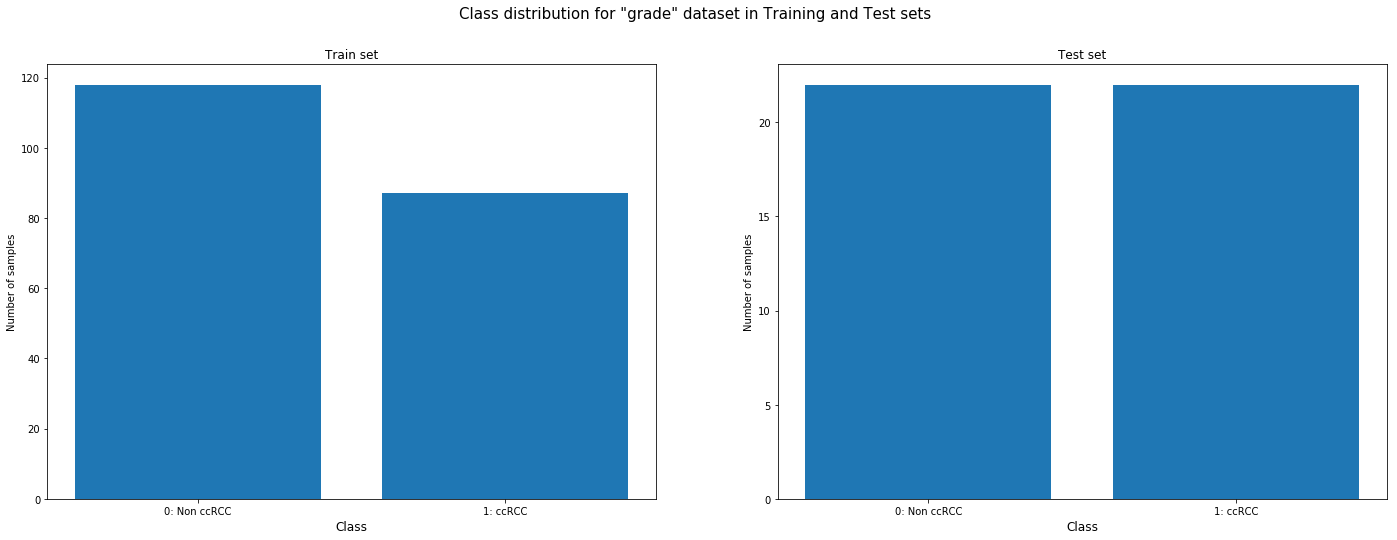

In [ ]:
# Create datasets
train_val_dataset = CNNDataset(data=X_train_cnn, data_rcc=y_train_cnn, patient_ids=id_train_cnn) 
test_dataset = CNNDataset(data=X_test_cnn, data_rcc=y_test_cnn, patient_ids=id_test_cnn)

plot_imbalance(train_val_dataset, test_dataset, "grade")

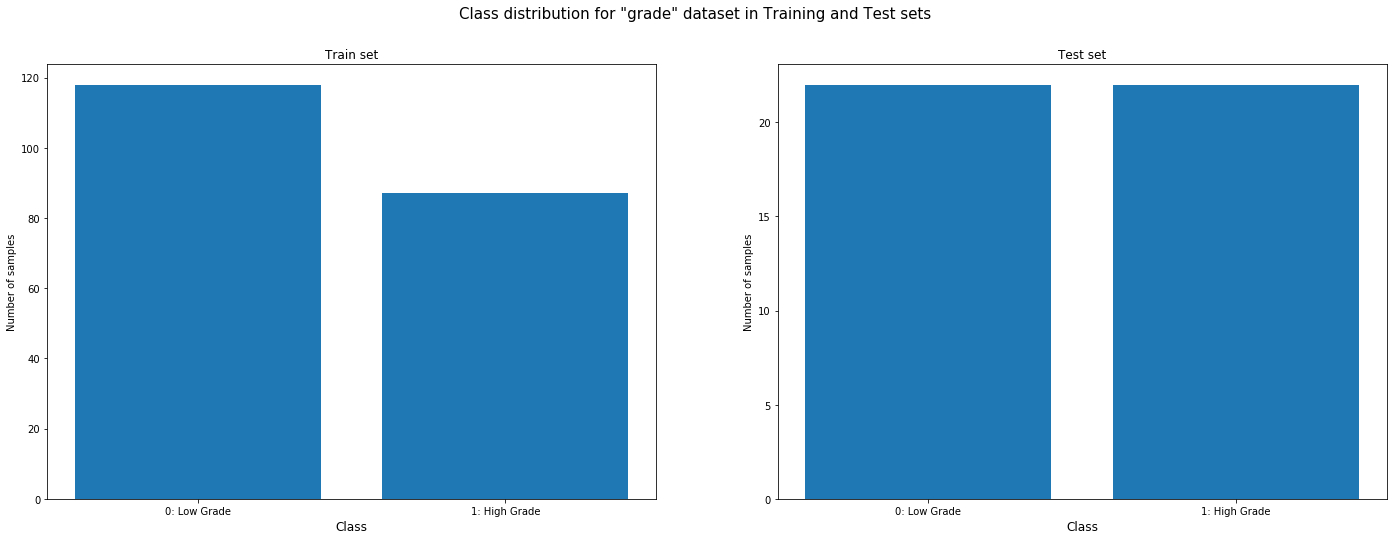

In [3]:
# Create datasets
train_val_dataset = CNNDataset(data=X_train_cnn, data_rcc=y_train_cnn, patient_ids=id_train_cnn) 
test_dataset = CNNDataset(data=X_test_cnn, data_rcc=y_test_cnn, patient_ids=id_test_cnn)

plot_imbalance(train_val_dataset, test_dataset, "grade")

# 2. Training - CNN 

In [3]:
import torch.nn as nn
from models.classification.classifier import _train, _evaluate

def cnn_classifier(model, 
                    X_train, 
                    y_train, 
                    id_train, 
                    aug_pos_data_dict_, 
                    aug_neg_data_dict_, 
                    task_name, 
                    kfold_mode,
                    max_epochs=10, 
                    patience=3, 
                    n_splits=5, 
                    n_repeats=10,
                    lr=0.001,
                    model_folder='/projects/renal/srm_detection_main/models/weights/classification',
                    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"), 
                    intermediate_output=True):
    
    if kfold_mode == "repeated":
        kf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)
    elif kfold_mode == "stratified":
        kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    else:
        raise ValueError("Enter a valid kfold mode !!!")

    all_train_losses = []
    all_val_losses = []
    all_train_accuracies = []
    all_val_accuracies = []
    all_roc_aucs = []  # To store roc_auc values for all folds
    best_thresholds = []
    fold_indices = []

    if task_name in ["ccRCC_vs_non_ccRCC", "grade", "subtype"]:
        aug_pos_data = aug_pos_data_dict_['img']
        aug_pos_labels = aug_pos_data_dict_['label']
        aug_pos_ids = aug_pos_data_dict_['Patient_ID']

        aug_neg_data = aug_neg_data_dict_['img']
        aug_neg_labels = aug_neg_data_dict_['label']
        aug_neg_ids = aug_neg_data_dict_['Patient_ID']
    else:
        raise ValueError("Enter a valid task name !!!")

    for fold, (train_index, val_index) in enumerate(kf.split(X_train, y_train)):
        print(f"Fold {fold + 1}/{n_splits}")

        fold_indices.append((train_index, val_index))

        X_train_fold = [X_train[i] for i in train_index]
        y_train_fold = [y_train[i] for i in train_index]
        id_train_fold = [id_train[i] for i in train_index]

        X_val_fold = [X_train[i] for i in val_index]
        y_val_fold = [y_train[i] for i in val_index]
        id_val_fold = [id_train[i] for i in val_index]

        X_train_fold.extend(aug_pos_data)
        y_train_fold.extend(aug_pos_labels)
        id_train_fold.extend(aug_pos_ids)

        X_train_fold.extend(aug_neg_data)
        y_train_fold.extend(aug_neg_labels)
        id_train_fold.extend(aug_neg_ids)

        train_fold_dataset = CNNDataset(data=X_train_fold, data_rcc=y_train_fold, patient_ids=id_train_fold)
        val_fold_dataset = CNNDataset(data=X_val_fold, data_rcc=y_val_fold, patient_ids=id_val_fold)

        train_fold_loader = FilteredDataLoader(train_fold_dataset, batch_size=32, shuffle=True)
        val_fold_loader = FilteredDataLoader(val_fold_dataset, batch_size=8, shuffle=True)

        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=patience, factor=0.5)
        criterion = nn.CrossEntropyLoss()

        best_loss = float('inf')
        patience_counter = 0

        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []
        roc_auc_fold = []  # To store roc_auc for each epoch in the current fold

        for epoch in range(max_epochs):
            train_loss, train_accuracy = _train(model, train_fold_loader, optimizer, criterion, device, intermediate_output)
            val_loss, val_accuracy, roc_auc_epoch, best_threshold = _evaluate(model, val_fold_loader, device, intermediate_output, y_val_fold)

            print(f'Epoch: {epoch+1} \t Training Loss: {train_loss:.5f} \t Training Accuracy: {train_accuracy:.5f} \t Validation Loss: {val_loss:.5f} \t Validation Accuracy: {val_accuracy:.5f}')
            print(f'Best roc/auc threshold for fold {fold + 1}: {best_threshold}')

            best_thresholds.append(best_threshold)

            scheduler.step(val_loss)

            if val_loss < best_loss:
                best_loss = val_loss
                patience_counter = 0
                best_model = model
                torch.save(model.state_dict(), os.path.join(model_folder, f'{task_name}/best_{task_name}_clf_fold_{fold + 1}.pth'))
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print("Early stopping triggered")
                break

            train_losses.append(train_loss)
            train_accuracies.append(train_accuracy)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)
            roc_auc_fold.append(roc_auc_epoch)  # Store roc_auc for the current epoch

        all_train_losses.append(train_losses)
        all_val_losses.append(val_losses)
        all_train_accuracies.append(train_accuracies)
        all_val_accuracies.append(val_accuracies)
        all_roc_aucs.append(roc_auc_fold)  # Store roc_auc for the current fold

    return all_train_losses, all_val_losses, all_train_accuracies, all_val_accuracies, best_thresholds, all_roc_aucs, fold_indices, best_model


In [4]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
clf = PatNET().to(device)

all_train_losses, all_val_losses, all_train_accuracies, all_val_accuracies, best_thresholds, roc_auc, fold_indices, best_cnn_model = cnn_classifier(clf,
               X_train_cnn,
               y_train_cnn,
               id_train_cnn,
               aug_pos_data_dict,
               aug_neg_data_dict,
               "grade",
               "stratified",
               max_epochs=15,
               patience = 3,
               n_splits=5)

Fold 1/5
Epoch: 1 	 Training Loss: 0.81151 	 Training Accuracy: 0.51718 	 Validation Loss: 0.69385 	 Validation Accuracy: 0.53659
Best roc/auc threshold for fold 1: 0.5039507150650024
Epoch: 2 	 Training Loss: 0.68486 	 Training Accuracy: 0.53318 	 Validation Loss: 0.71199 	 Validation Accuracy: 0.60976
Best roc/auc threshold for fold 1: 0.49461615085601807
Epoch: 3 	 Training Loss: 0.67130 	 Training Accuracy: 0.56518 	 Validation Loss: 0.63157 	 Validation Accuracy: 0.70732
Best roc/auc threshold for fold 1: 0.49376073479652405
Epoch: 4 	 Training Loss: 0.65830 	 Training Accuracy: 0.57176 	 Validation Loss: 0.60766 	 Validation Accuracy: 0.70732
Best roc/auc threshold for fold 1: 0.49775516986846924
Epoch: 5 	 Training Loss: 0.63991 	 Training Accuracy: 0.59765 	 Validation Loss: 0.67122 	 Validation Accuracy: 0.65854
Best roc/auc threshold for fold 1: 0.6555679440498352
Epoch: 6 	 Training Loss: 0.73327 	 Training Accuracy: 0.56941 	 Validation Loss: 0.62903 	 Validation Accuracy: 

In [9]:
import numpy as np
from sklearn.utils import resample

# Define the bootstrap_ci function
def bootstrap_ci(values, n_bootstrap=1000, confidence_level=0.95):
    """Calculate the bootstrap confidence interval."""
    bootstrap_samples = []
    for _ in range(n_bootstrap):
        sample = resample(values, replace=True, n_samples=len(values))
        bootstrap_samples.append(np.mean(sample))  # Calculate mean for each sample

    lower = np.percentile(bootstrap_samples, (1 - confidence_level) / 2 * 100)
    upper = np.percentile(bootstrap_samples, (1 + confidence_level) / 2 * 100)
    return lower, upper

# List to store confidence intervals for each fold
fold_ci = []

# Iterate through each fold's roc_auc values
for i, fold_roc_auc in enumerate(roc_auc):
    # Calculate mean and std for the current fold
    mean_auc = np.mean(fold_roc_auc)
    std_auc = np.std(fold_roc_auc)
    
    # Apply bootstrap_ci to the current fold's ROC AUC values
    low_ic, up_ic = bootstrap_ci(fold_roc_auc)
    
    # Print the result in the desired format
    print(f"Fold {i+1}: (AUC) mean ± std : {mean_auc:.3f} ± {std_auc:.3f} ({low_ic:.2f}, {up_ic:.2f})")


Fold 1: (AUC) mean ± std : 0.613 ± 0.138 (0.51, 0.71)
Fold 2: (AUC) mean ± std : 0.624 ± 0.069 (0.55, 0.68)
Fold 3: (AUC) mean ± std : 0.917 ± 0.021 (0.90, 0.93)
Fold 4: (AUC) mean ± std : 0.992 ± 0.010 (0.98, 1.00)
Fold 5: (AUC) mean ± std : 1.000 ± 0.000 (1.00, 1.00)


In [10]:
'''low_ic, up_ic = bootstrap_ci(roc_auc)
print(f"(AUC) mean ± std : {np.mean(roc_auc):.3f} ± {np.std(roc_auc):.3f} ({low_ic:.2f},{up_ic:.2f})")'''

'low_ic, up_ic = bootstrap_ci(roc_auc)\nprint(f"(AUC) mean ± std : {np.mean(roc_auc):.3f} ± {np.std(roc_auc):.3f} ({low_ic:.2f},{up_ic:.2f})")'

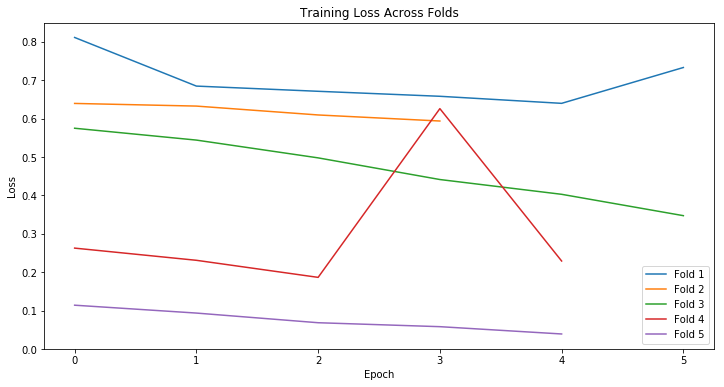

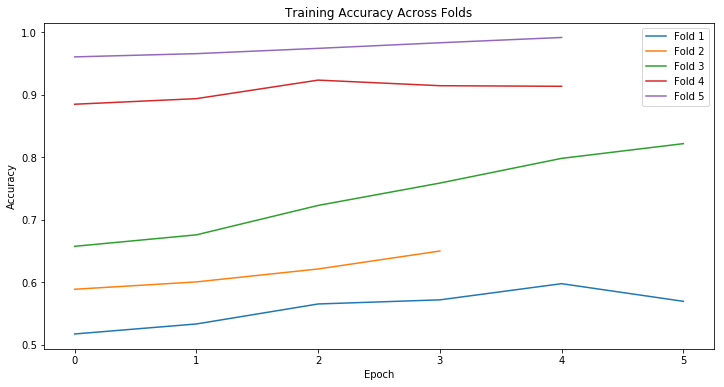

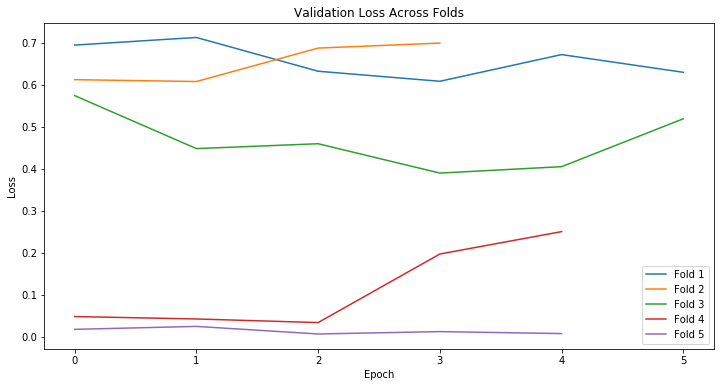

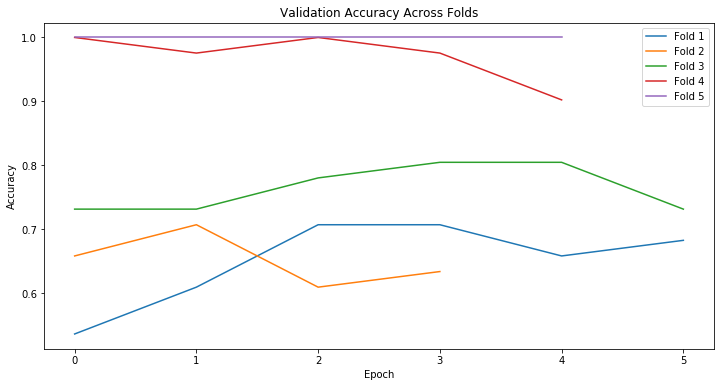

In [11]:
plot_metrics_folds(all_train_losses, all_train_accuracies, all_val_losses, all_val_accuracies, num_folds=5)

# 3. Training - XGBOOST (On radiomics)

In [ ]:
def xgboost_trainer(task_name, model_file_path, aug_pos_data_dict, aug_neg_data_dict, pos_data_dict, neg_data_dict, num_pos, num_neg, num_attempts=10):
    results = []
    
    for attempt in range(num_attempts):
        
        X_train_xgb, y_train_xgb, X_test_xgb, y_test_xgb, X_train_xgb_aug, y_train_xgb_aug = load_xgboost_data(task_name, 
                                                                                                               aug_pos_data_dict, 
                                                                                                               aug_neg_data_dict, 
                                                                                                               pos_data_dict, 
                                                                                                               neg_data_dict, 
                                                                                                               num_pos,                                                                                                    
                                                                                                               num_neg)        
        # Train XGBoost model
        # model_xgb = xgboost(X_train_xgb_aug, X_test_xgb, y_train_xgb_aug, y_test_xgb) 
        model_xgb = calibrated_xgboost(X_train_xgb_aug, X_test_xgb, y_train_xgb_aug, y_test_xgb) 

        print(model_xgb)
        # Save the model
        model_xgb['model'].save_model(os.path.join(model_file_path, f"xgboost_model_attempt_{attempt}.bin"))
        print(f"Model saved to {model_file_path}")
        results.append(model_xgb)

    return results


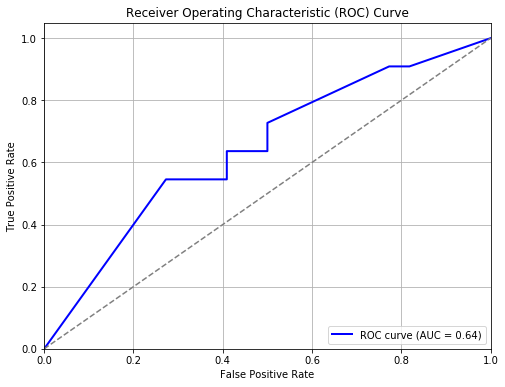

<Figure size 576x432 with 0 Axes>

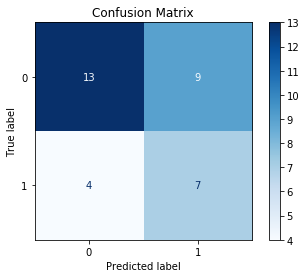

{'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...), 'selected_features': array([ True,  True,  True]), 'best_params': {'colsample_bytree': 0.7, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.7999999999999999}, 'accuracy': 0.6060606060606061, 'precis

[15:46:01] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


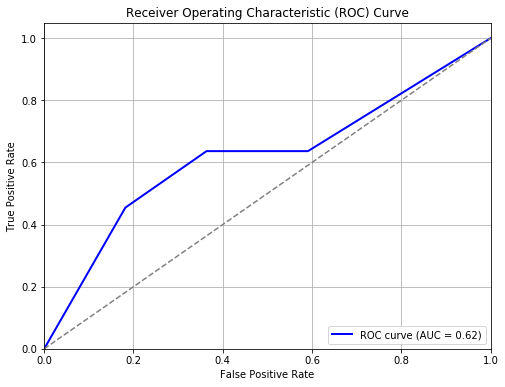

<Figure size 576x432 with 0 Axes>

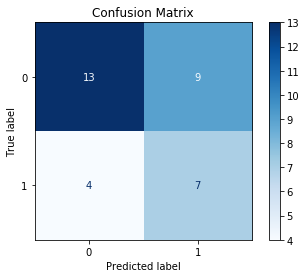

{'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9999999999999999, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.2, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.25, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=11,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...), 'selected_features': array([ True,  True,  True]), 'best_params': {'colsample_bytree': 0.9999999999999999, 'gamma': 0.2, 'learning_rate': 0.25, 'max_depth': 11, 'n_estimators': 500, 'subsample': 0.8999999999999999}, 'accu

[15:52:55] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


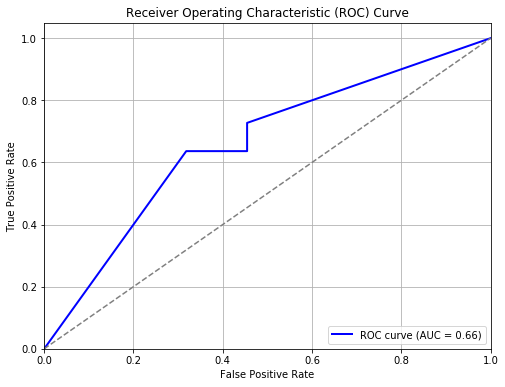

<Figure size 576x432 with 0 Axes>

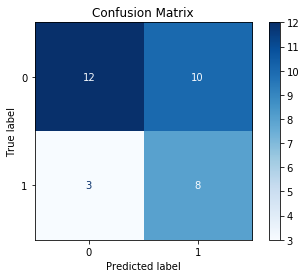

{'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=11, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...), 'selected_features': array([ True,  True,  True]), 'best_params': {'colsample_bytree': 0.7, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 11, 'n_estimators': 100, 'subsample': 0.9999999999999999}, 'accuracy': 0.6060606060606061, 'prec

[17:01:10] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


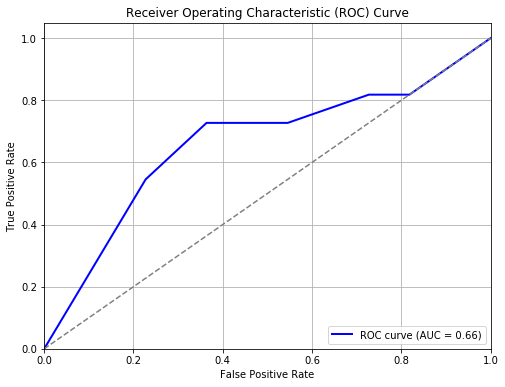

<Figure size 576x432 with 0 Axes>

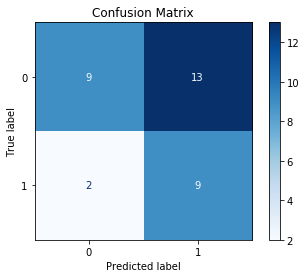

{'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9999999999999999, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.3, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=11,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...), 'selected_features': array([ True,  True,  True]), 'best_params': {'colsample_bytree': 0.9999999999999999, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 11, 'n_estimators': 100, 'subsample': 0.9999999999999999}, 'accura

[18:20:07] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


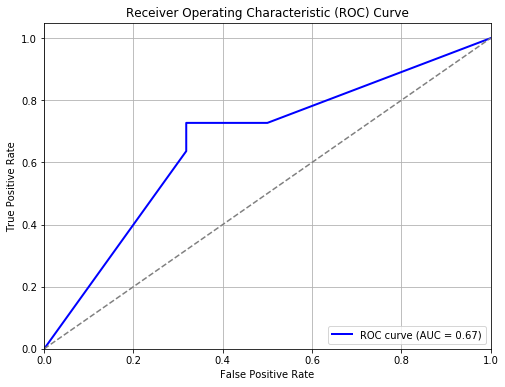

<Figure size 576x432 with 0 Axes>

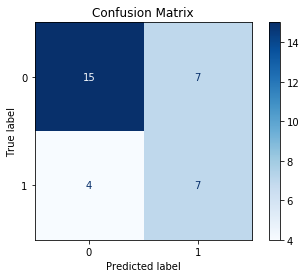

{'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9999999999999999, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.3, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...), 'selected_features': array([ True,  True,  True]), 'best_params': {'colsample_bytree': 0.9999999999999999, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.9999999999999999}, 'accuracy

[19:37:01] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


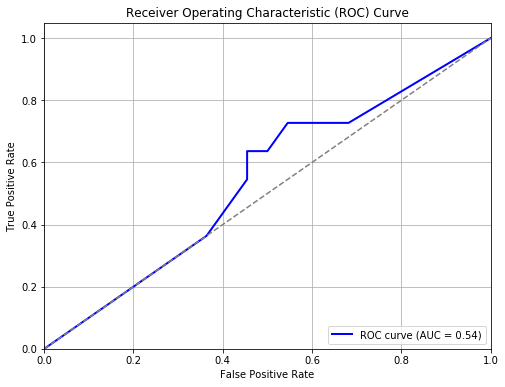

<Figure size 576x432 with 0 Axes>

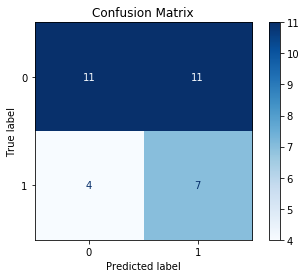

{'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9999999999999999, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.2, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.25, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...), 'selected_features': array([ True,  True,  True]), 'best_params': {'colsample_bytree': 0.9999999999999999, 'gamma': 0.2, 'learning_rate': 0.25, 'max_depth': 9, 'n_estimators': 500, 'subsample': 0.7999999999999999}, 'accura

[20:57:01] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


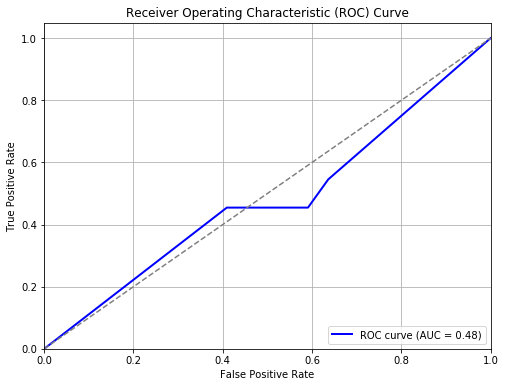

<Figure size 576x432 with 0 Axes>

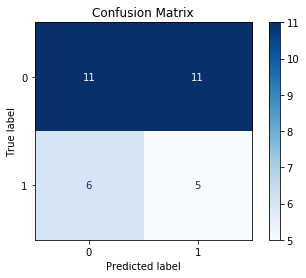

{'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=11, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...), 'selected_features': array([ True,  True,  True]), 'best_params': {'colsample_bytree': 0.7, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 11, 'n_estimators': 100, 'subsample': 0.9999999999999999}, 'accuracy': 0.48484848484848486, 'pre

[22:13:53] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [14]:
all_xgb_models = xgboost_trainer("grade", "/projects/renal/srm_detection_main/models/weights/classification/grade/xgboost", aug_pos_data_dict, aug_neg_data_dict, pos_data_dict, neg_data_dict, num_pos=291, num_neg=260)

In [3]:
X_train_xgb, y_train_xgb, X_test_xgb, y_test_xgb, X_train_xgb_aug, y_train_xgb_aug = load_xgboost_data("grade", aug_pos_data_dict, aug_neg_data_dict, pos_data_dict, neg_data_dict, num_pos=291, num_neg=260)

In [ ]:
# test with xgb model 1
xgb_probs_1 = get_xgb_predictions(all_xgb_models[1], X_test_xgb)
# test with xgb model 6
xgb_probs_6 = get_xgb_predictions(all_xgb_models[6], X_test_xgb)

In [16]:
# or load best xgboost model

xgb_model_file = '/projects/renal/srm_detection_main/models/weights_draft/classification/grade/xgboost/xgboost_model_attempt_1_more_aug_600.bin'
best_xgb_model = xgb.XGBClassifier()
best_xgb_model.load_model(xgb_model_file)

xgb_probs = get_xgb_predictions(best_xgb_model, X_test_xgb)

# 4. Evaluation

### I. XGBOOST

In [9]:
import pandas as pd
for i in range(10):
    xgb_model_file = f'/projects/renal/srm_detection_main/models/weights_draft/classification/grade/xgboost/xgboost_model_attempt_{i}_more_aug_600.bin'
    best_xgb_model = xgb.XGBClassifier()
    best_xgb_model.load_model(xgb_model_file)

    xgb_probs = get_xgb_predictions(best_xgb_model, X_test_xgb)
    # Stratified K-Fold on the test set
    skf = StratifiedKFold(n_splits=5)
    test_results = []

    roc_aucs = []
    sensitivities = []
    specificities = []

    for fold, (train_index, test_index) in enumerate(skf.split(X_test_xgb, y_test_xgb)):
        X_true = np.array([X_test_xgb[i] for i in test_index])
        y_true = np.array([y_test_xgb[i] for i in test_index])
        y_probs = get_xgb_predictions(best_xgb_model, X_true)
        y_preds = (y_probs > 0.5).astype(int)

        metrics_report = evaluate_model(y_true, y_preds, y_probs)
        roc_aucs.append(metrics_report['ROC AUC'])
        sensitivities.append(metrics_report['Sensitivity'])
        specificities.append(metrics_report['Specificity'])
        
        # Append results to the list
        test_results.append({
            'Fold': fold + 1,
            'ROC AUC': metrics_report['ROC AUC'],
            'Sensitivity': metrics_report['Sensitivity'],
            'Specificity': metrics_report['Specificity']
        })

    # Convert results to a DataFrame
    df_results = pd.DataFrame(test_results)

    # Calculate bootstrap confidence intervals
    roc_auc_ci_L, roc_auc_ci_U = bootstrap_ci(roc_aucs)
    sensitivity_ci_L, sensitivity_ci_U = bootstrap_ci(sensitivities)
    specificity_ci_L, specificity_ci_U  = bootstrap_ci(specificities)

    # Display the per-fold results
    print("Per-Fold Results:")
    print(df_results)

    # Calculate and display the summary statistics
    summary_stats = pd.DataFrame({
        'Metric': ['ROC AUC', 'Sensitivity', 'Specificity'],
        'Mean ± Std': [
            f"{np.mean(roc_aucs):.3f} ± {np.std(roc_aucs):.3f}",
            f"{np.mean(sensitivities):.3f} ± {np.std(sensitivities):.3f}",
            f"{np.mean(specificities):.3f} ± {np.std(specificities):.3f}"
        ],
        '95% CI': [
            f"{roc_auc_ci_L:.3f} - {roc_auc_ci_U:.3f}",
            f"{sensitivity_ci_L:.3f} - {sensitivity_ci_U:.3f}",
            f"{specificity_ci_L:.3f} - {specificity_ci_U:.3f}"
        ]
    })

    print("\nSummary Statistics:")
    print(summary_stats)


Per-Fold Results:
   Fold   ROC AUC  Sensitivity  Specificity
0     1  1.000000     1.000000         0.60
1     2  0.600000     0.500000         0.20
2     3  0.666667     0.333333         0.50
3     4  0.750000     1.000000         0.75
4     5  0.750000     1.000000         0.75

Summary Statistics:
        Metric     Mean ± Std         95% CI
0      ROC AUC  0.753 ± 0.136  0.600 - 1.000
1  Sensitivity  0.767 ± 0.291  0.333 - 1.000
2  Specificity  0.560 ± 0.203  0.200 - 0.750


Per-Fold Results:
   Fold  ROC AUC  Sensitivity  Specificity
0     1      0.7     0.500000         0.40
1     2      0.6     0.500000         0.60
2     3      0.5     0.666667         0.50
3     4      1.0     1.000000         0.75
4     5      1.0     1.000000         0.50

Summary Statistics:
        Metric     Mean ± Std         95% CI
0      ROC AUC  0.760 ± 0.206  0.500 - 1.000
1  Sensitivity  0.733 ± 0.226  0.500 - 1.000
2  Specificity  0.550 ± 0.118  0.400 - 0.750
Per-Fold Results:
   Fold   ROC AUC  Sensitivity  Specificity
0     1  0.700000     0.500000         0.60
1     2  0.600000     0.500000         0.40
2     3  0.666667     0.666667         0.50
3     4  0.875000     1.000000         0.50
4     5  0.875000     1.000000         0.75

Summary Statistics:
        Metric     Mean ± Std         95% CI
0      ROC AUC  0.743 ± 0.112  0.600 - 0.875
1  Sensitivity  0.733 ± 0.226  0.500 - 1.000
2  Specificity  0.550 ± 0.118  0.400 - 0.750
Per-Fold Results:
   Fold   ROC AUC  Sen

In [8]:
import pandas as pd

# Stratified K-Fold on the test set
skf = StratifiedKFold(n_splits=5)
test_results = []

roc_aucs = []
sensitivities = []
specificities = []

for fold, (train_index, test_index) in enumerate(skf.split(X_test_xgb, y_test_xgb)):
    X_true = np.array([X_test_xgb[i] for i in test_index])
    y_true = np.array([y_test_xgb[i] for i in test_index])
    y_probs = get_xgb_predictions(best_xgb_model, X_true)
    y_preds = (y_probs > 0.5).astype(int)

    metrics_report = evaluate_model(y_true, y_preds, y_probs)
    roc_aucs.append(metrics_report['ROC AUC'])
    sensitivities.append(metrics_report['Sensitivity'])
    specificities.append(metrics_report['Specificity'])
    
    # Append results to the list
    test_results.append({
        'Fold': fold + 1,
        'ROC AUC': metrics_report['ROC AUC'],
        'Sensitivity': metrics_report['Sensitivity'],
        'Specificity': metrics_report['Specificity']
    })

# Convert results to a DataFrame
df_results = pd.DataFrame(test_results)

# Calculate bootstrap confidence intervals
roc_auc_ci_L, roc_auc_ci_U = bootstrap_ci(roc_aucs)
sensitivity_ci_L, sensitivity_ci_U = bootstrap_ci(sensitivities)
specificity_ci_L, specificity_ci_U  = bootstrap_ci(specificities)

# Display the per-fold results
print("Per-Fold Results:")
print(df_results)

# Calculate and display the summary statistics
summary_stats = pd.DataFrame({
    'Metric': ['ROC AUC', 'Sensitivity', 'Specificity'],
    'Mean ± Std': [
        f"{np.mean(roc_aucs):.3f} ± {np.std(roc_aucs):.3f}",
        f"{np.mean(sensitivities):.3f} ± {np.std(sensitivities):.3f}",
        f"{np.mean(specificities):.3f} ± {np.std(specificities):.3f}"
    ],
    '95% CI': [
        f"{roc_auc_ci_L:.3f} - {roc_auc_ci_U:.3f}",
        f"{sensitivity_ci_L:.3f} - {sensitivity_ci_U:.3f}",
        f"{specificity_ci_L:.3f} - {specificity_ci_U:.3f}"
    ]
})

print("\nSummary Statistics:")
print(summary_stats)


Per-Fold Results:
   Fold   ROC AUC  Sensitivity  Specificity
0     1  0.800000     0.500000         0.60
1     2  0.600000     0.500000         0.40
2     3  0.583333     0.666667         0.50
3     4  0.750000     0.500000         0.75
4     5  1.000000     1.000000         0.50

Summary Statistics:
        Metric     Mean ± Std         95% CI
0      ROC AUC  0.747 ± 0.152  0.583 - 1.000
1  Sensitivity  0.633 ± 0.194  0.500 - 1.000
2  Specificity  0.550 ± 0.118  0.400 - 0.750


### II. CNN

In [15]:

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_cnn_model = PatNET().to(device)
# Load the state dict on CPU of the 43th CNN Model (Best one)
best_cnn_model.load_state_dict(torch.load('/projects/renal/srm_detection_main/models/weights/classification/grade/best_grade_clf_fold_5.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [14]:
import numpy as np
import pandas as pd


for i in range(1,6):
    best_cnn_model.load_state_dict(torch.load(f'/projects/renal/srm_detection_main/models/weights/classification/grade/best_grade_clf_fold_{i}.pth', map_location=torch.device('cpu')))    # Stratified K-Fold on the test set
    skf = StratifiedKFold(n_splits=5)
    test_results = []

    roc_aucs = []
    sensitivities = []
    specificities = []

    for fold, (train_index, test_index) in enumerate(skf.split(X_test_cnn, y_test_cnn)):
        X_true = [X_test_cnn[i] for i in test_index]  # Keep as a list
        y_true = np.array([y_test_cnn[i] for i in test_index])

        y_probs = get_cnn_predictions(best_cnn_model, X_true, device)
        
        # Ensure y_probs is a NumPy array
        y_probs = np.array(y_probs)
        
        # Perform the comparison to generate binary predictions
        y_preds = (y_probs > 0.5).astype(int)
        
        metrics_report = evaluate_model(y_true, y_preds, y_probs)

        roc_aucs.append(metrics_report['ROC AUC'])
        sensitivities.append(metrics_report['Sensitivity'])
        specificities.append(metrics_report['Specificity'])

        # Append results to the list
        test_results.append({
            'Fold': fold + 1,
            'ROC AUC': metrics_report['ROC AUC'],
            'Sensitivity': metrics_report['Sensitivity'],
            'Specificity': metrics_report['Specificity']
        })

    # Convert results to a DataFrame
    df_results = pd.DataFrame(test_results)

    # Calculate bootstrap confidence intervals
    roc_auc_ci_L, roc_auc_ci_U = bootstrap_ci(roc_aucs)
    sensitivity_ci_L, sensitivity_ci_U = bootstrap_ci(sensitivities)
    specificity_ci_L, specificity_ci_U  = bootstrap_ci(specificities)

    # Display the per-fold results
    print("Per-Fold Results:")
    print(df_results)


    # Calculate means and standard deviations
    roc_auc_mean = np.mean(roc_aucs)
    roc_auc_std = np.std(roc_aucs)
    sensitivity_mean = np.mean(sensitivities)
    sensitivity_std = np.std(sensitivities)
    specificity_mean = np.mean(specificities)
    specificity_std = np.std(specificities)

    # Calculate bootstrap confidence intervals
    roc_auc_ci_L, roc_auc_ci_U = bootstrap_ci(roc_aucs)
    sensitivity_ci_L, sensitivity_ci_U = bootstrap_ci(sensitivities)
    specificity_ci_L, specificity_ci_U = bootstrap_ci(specificities)

    # Create a summary DataFrame
    summary_df = pd.DataFrame({
        'Metric': ['ROC AUC', 'Sensitivity', 'Specificity'],
        'Mean ± Std': [
            f"{roc_auc_mean:.3f} ± {roc_auc_std:.3f}",
            f"{sensitivity_mean:.3f} ± {sensitivity_std:.3f}",
            f"{specificity_mean:.3f} ± {specificity_std:.3f}"
        ],
        '95% CI': [
            f"{roc_auc_ci_L:.3f} - {roc_auc_ci_U:.3f}",
            f"{sensitivity_ci_L:.3f} - {sensitivity_ci_U:.3f}",
            f"{specificity_ci_L:.3f} - {specificity_ci_U:.3f}"
        ]
    })

    print()
    print(summary_df)


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


Per-Fold Results:
   Fold  ROC AUC  Sensitivity  Specificity
0     1     0.25          0.0         1.00
1     2     0.50          0.4         0.75
2     3     0.55          0.5         0.60
3     4     0.45          0.0         1.00
4     5     0.50          0.0         1.00

        Metric     Mean ± Std         95% CI
0      ROC AUC  0.450 ± 0.105  0.250 - 0.550
1  Sensitivity  0.180 ± 0.223  0.000 - 0.500
2  Specificity  0.870 ± 0.166  0.600 - 1.000


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


Per-Fold Results:
   Fold  ROC AUC  Sensitivity  Specificity
0     1     0.45          0.2         1.00
1     2     0.80          0.6         0.75
2     3     0.55          0.5         0.60
3     4     0.55          0.0         1.00
4     5     0.25          0.0         1.00

        Metric     Mean ± Std         95% CI
0      ROC AUC  0.520 ± 0.178  0.250 - 0.800
1  Sensitivity  0.260 ± 0.250  0.000 - 0.600
2  Specificity  0.870 ± 0.166  0.600 - 1.000
Per-Fold Results:
   Fold  ROC AUC  Sensitivity  Specificity
0     1   0.8000         0.80         1.00
1     2   1.0000         0.80         1.00
2     3   0.8250         0.75         0.80
3     4   1.0000         1.00         1.00
4     5   0.4375         0.25         0.75

        Metric     Mean ± Std         95% CI
0      ROC AUC  0.812 ± 0.206  0.438 - 1.000
1  Sensitivity  0.720 ± 0.250  0.250 - 1.000
2  Specificity  0.910 ± 0.111  0.750 - 1.000
Per-Fold Results:
   Fold  ROC AUC  Sensitivity  Specificity
0     1   0.7000         

# Ensembling

### Approach 1: Stacking CNN + XGBOOST Predictions

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from imblearn.ensemble import BalancedRandomForestClassifier, BalancedBaggingClassifier

# Define meta-models
meta_models = {
    'Logistic Regression': LogisticRegression(),
    'LightGBM': lgb.LGBMClassifier(),
    'Balanced Random Forest': BalancedRandomForestClassifier(),
    'Balanced Gradient Boosting': BalancedBaggingClassifier(estimator=GradientBoostingClassifier(), sampling_strategy='auto'),
}

# Train meta-models and generate predictions
roc_curves = {}
classification_reports = {}

# Generate predictions on the training data
cnn_train_probs = get_cnn_predictions(best_cnn_model, X_train_cnn, device)
xgb_train_probs = get_xgb_predictions(best_xgb_model, X_train_xgb)

print(len(cnn_train_probs))
print(len(xgb_train_probs))
# Stack training predictions
stacked_X_train = np.vstack((cnn_train_probs, xgb_train_probs[2:])).T


for name, model in meta_models.items():
    # Train the meta-model
    model.fit(stacked_X_train, y_train_cnn)
    
    # Generate predictions on the test data
    cnn_test_probs = get_cnn_predictions(best_cnn_model, X_test_cnn, device)
    xgb_test_probs = get_xgb_predictions(best_xgb_model, X_test_xgb)
    # Stack training predictions
    stacked_X_test = np.vstack((cnn_test_probs, xgb_test_probs)).T
    
    # Make final predictions with the meta-model
    test_probs = model.predict_proba(stacked_X_test)[:, 1]
    
    fpr, tpr, _ = roc_curve(y_test_cnn, test_probs)
    roc_auc = roc_auc_score(y_test_cnn, test_probs)
    
    # Store ROC curve data
    roc_curves[name] = (fpr, tpr, roc_auc)
    
    # Generate classification report
    final_predictions = model.predict(stacked_X_test)
    classification_reports[name] = classification_report(y_test_cnn, final_predictions)

# Plot ROC Curves
plt.figure(figsize=(12, 8))
for name, (fpr, tpr, auc) in roc_curves.items():
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves of Meta-Models')
plt.legend()
plt.show()

# Print Classification Reports
for name, report in classification_reports.items():
    print(f"{name} Classification Report:")
    print(report)
    print("\n")


205
216


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 205 and the array at index 1 has size 214

### Approach 2: XGBOOST trained on CNN Features + Radiomics

CNN-Based Feature Extraction: CNNs is used to extract deep features from medical images. These features are then fed into traditional machine learning models (e.g., XGBoost, random forests).

In [ ]:
train_index, val_index = fold_indices[2] # select a random fold set for training
train_intermediate_outputs, test_intermediate_outputs, train_loader, test_loader, y_train = get_intermediate_cnn_features(X_train_cnn, 
                                                                                                                                y_train_cnn,
                                                                                                                                id_train_cnn,
                                                                                                                                aug_pos_data_dict,
                                                                                                                                aug_neg_data_dict,
                                                                                                                                train_index, 
                                                                                                                                val_index, 
                                                                                                                                best_cnn_model, 
                                                                                                                                device)

In [ ]:
train_intermediate_outputs_df = pd.DataFrame(train_intermediate_outputs.cpu().numpy())
train_intermediate_outputs_df.head()

In [ ]:
test_intermediate_outputs_df = pd.DataFrame(test_intermediate_outputs.cpu().numpy())
test_intermediate_outputs_df.head()

In [ ]:
X_train = stack_deep_radiomics_features(train_loader, train_intermediate_outputs)
X_test = stack_deep_radiomics_features(test_loader, test_intermediate_outputs)

xgb_cnn_rads_model = xgboost(X_train, X_test, y_train, y_test_cnn)
xgb_cnn_rads_model

### Approach 3: XGBOOST Trained on CNN Features

In [ ]:
xgb_cnn_features_model = xgboost(X_train['cnn_features'], X_test['cnn_features'], y_train, y_test_cnn)
xgb_cnn_features_model

# Model Calibration